In [1]:
import pandas as pd, re
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import calendar
import matplotlib.dates as mdates
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import math
import holidays
from operator import itemgetter

In [2]:
df = pd.read_csv('demandForecastingData.csv', parse_dates=['Date'])

In [3]:
df['Temperature-18hrs'] = pd.to_numeric(df['Temperature-18hrs'], errors='coerce')

In [4]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Quarter', 'Hour', 'Minute', 'Day', 'Dayofweek', 'Dayofyear']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)
        

In [5]:
add_datepart(df, 'Date', drop=False)

In [6]:
#2018-07-01 00:00:00
#2013-01-01 00:00:00
end_date = datetime(2018, 7, 1)
start_date = datetime(2013, 1, 1)

start_date_displaced_day = start_date - timedelta(minutes=1440)
end_date_displaced_day = end_date - timedelta(minutes=1440)

start_date_displaced_week = start_date - timedelta(minutes=10080)
end_date_displaced_week = end_date - timedelta(minutes=10080)

start_date_displaced_year = start_date - timedelta(minutes=524160)
end_date_displaced_year = end_date - timedelta(minutes=524160)

ranged_df = df[(df.Date >= start_date) & (df.Date <= end_date)].reset_index(drop=True)

df_same_day_displaced  = df[(df.Date >= start_date_displaced_day) & (df.Date <= end_date_displaced_day)].reset_index(drop=True)
df_same_week_displaced  = df[(df.Date >= start_date_displaced_week) & (df.Date <= end_date_displaced_week)].reset_index(drop=True)
df_same_year_displaced  = df[(df.Date >= start_date_displaced_year) & (df.Date <= end_date_displaced_year)].reset_index(drop=True)

ranged_df['Load Last Day'] = df_same_day_displaced['Load']
ranged_df['Load Last Week'] = df_same_week_displaced['Load']
ranged_df['Load Last Year'] = df_same_year_displaced['Load']

ranged_df.head()

,Date,Load,Temperature,Temperature-6hrs,Temperature-12hrs,Temperature-18hrs,Temperature-24hrs,Temperature-36hrs,Temperature-48hrs,Temperature-72hrs,...,Week,Quarter,Hour,Minute,Day,Dayofweek,Dayofyear,Load Last Day,Load Last Week,Load Last Year
0,2013-01-01 00:00:00,840.57,2.7,4.4,6.8,9.9,9.8,8.2,4.7,2.4,...,1,1,0,0,1,1,1,784.39,868.02,865.41
1,2013-01-01 00:30:00,819.25,2.7,4.4,6.8,9.9,9.8,8.2,4.7,2.4,...,1,1,0,30,1,1,1,744.19,805.28,833.36
2,2013-01-01 01:00:00,818.26,2.7,4.0,6.8,10.0,10.1,9.3,5.0,2.4,...,1,1,1,0,1,1,1,743.33,789.54,823.01
3,2013-01-01 01:30:00,799.11,2.7,4.0,6.8,10.0,10.1,9.3,5.0,2.4,...,1,1,1,30,1,1,1,726.10,751.77,809.48
4,2013-01-01 02:00:00,764.40,3.1,3.3,7.2,10.0,10.2,9.6,5.7,2.8,...,1,1,2,0,1,1,1,704.08,709.98,797.16


In [7]:
plt.figure(figsize=(20,20))

hourlycorrelation = pd.DataFrame(columns=['Hour', 'Correlation'])
for i in range(0, 24):
    specifichour = ranged_df[(ranged_df['Hour'] == i) & (ranged_df['Minute'] == 0)]
    specifichalfhour =  ranged_df[(ranged_df['Hour'] == i) & (ranged_df['Minute'] == 30)]
    specifichourcorrelation = specifichour.corr()['Load']['Load Last Year']
    specifichalfhourcorrelation = specifichalfhour.corr()['Load']['Load Last Year']
    hourlycorrelation = hourlycorrelation.append({'Hour': datetime(2015, 1, 1, i, 0, 0, 0), 'Correlation': specifichourcorrelation}, ignore_index=True)
    hourlycorrelation = hourlycorrelation.append({'Hour': datetime(2015, 1, 1, i, 30, 0, 0), 'Correlation': specifichalfhourcorrelation}, ignore_index=True)


    print (F"{i}:00 : {specifichourcorrelation}")
    print (F"{i}:30 : {specifichalfhourcorrelation}")
    
hourlycorrelation.set_index('Hour', inplace=True)
hourlycorrelation.head()

0:00 : 0.5942611898916121
0:30 : 0.6780016733159524
1:00 : 0.8287339256573595
1:30 : 0.8475971501439629
2:00 : 0.8250114203049326
2:30 : 0.8073685242287991
3:00 : 0.8288897433406122
3:30 : 0.8386616453660055
4:00 : 0.8507047116661504
4:30 : 0.8608984117343135
5:00 : 0.8781108447801428
5:30 : 0.882087593062861
6:00 : 0.8426173789071826
6:30 : 0.816851677628234
7:00 : 0.811748837814385
7:30 : 0.8498453049324948
8:00 : 0.8690700703375696
8:30 : 0.8713006781952312
9:00 : 0.8659510406232515
9:30 : 0.8672337309748183
10:00 : 0.8642961550696334
10:30 : 0.866703915510805
11:00 : 0.8631513038799826
11:30 : 0.860594240629403
12:00 : 0.8550415032029931
12:30 : 0.8488864321495724
13:00 : 0.8323404829331463
13:30 : 0.8317098178895594
14:00 : 0.8470296034583521
14:30 : 0.8537131871432759
15:00 : 0.8630585402268223
15:30 : 0.8688926650799547
16:00 : 0.876001083250346
16:30 : 0.8810838142144022
17:00 : 0.899267351609223
17:30 : 0.919885688009242
18:00 : 0.9234735753060415
18:30 : 0.9265013930534912
19

,Correlation
Hour,
2015-01-01 00:00:00,0.594261
2015-01-01 00:30:00,0.678002
2015-01-01 01:00:00,0.828734
2015-01-01 01:30:00,0.847597
2015-01-01 02:00:00,0.825011


<Figure size 1440x1440 with 0 Axes>

[datetime.time(0, 0) datetime.time(0, 30) datetime.time(1, 0)
 datetime.time(1, 30) datetime.time(2, 0) datetime.time(2, 30)
 datetime.time(3, 0) datetime.time(3, 30) datetime.time(4, 0)
 datetime.time(4, 30) datetime.time(5, 0) datetime.time(5, 30)
 datetime.time(6, 0) datetime.time(6, 30) datetime.time(7, 0)
 datetime.time(7, 30) datetime.time(8, 0) datetime.time(8, 30)
 datetime.time(9, 0) datetime.time(9, 30) datetime.time(10, 0)
 datetime.time(10, 30) datetime.time(11, 0) datetime.time(11, 30)
 datetime.time(12, 0) datetime.time(12, 30) datetime.time(13, 0)
 datetime.time(13, 30) datetime.time(14, 0) datetime.time(14, 30)
 datetime.time(15, 0) datetime.time(15, 30) datetime.time(16, 0)
 datetime.time(16, 30) datetime.time(17, 0) datetime.time(17, 30)
 datetime.time(18, 0) datetime.time(18, 30) datetime.time(19, 0)
 datetime.time(19, 30) datetime.time(20, 0) datetime.time(20, 30)
 datetime.time(21, 0) datetime.time(21, 30) datetime.time(22, 0)
 datetime.time(22, 30) datetime.time(2

([<matplotlib.axis.XTick at 0x25fda0d46a0>,
 <a list of 24 Text xticklabel objects>)

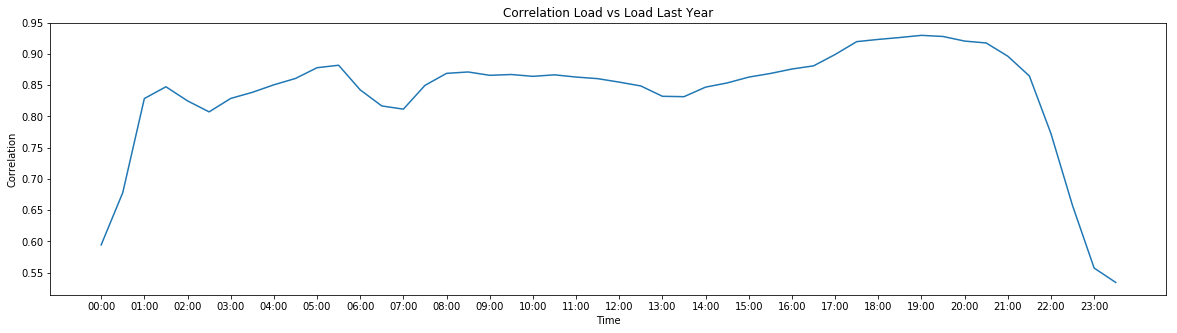

In [8]:
print((hourlycorrelation.index.time))
plt.figure(figsize=(20,5))
plt.plot(hourlycorrelation.index.time, hourlycorrelation['Correlation'])
plt.title('Correlation Load vs Load Last Year')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.xticks(hourlycorrelation.index.time[0::2])

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


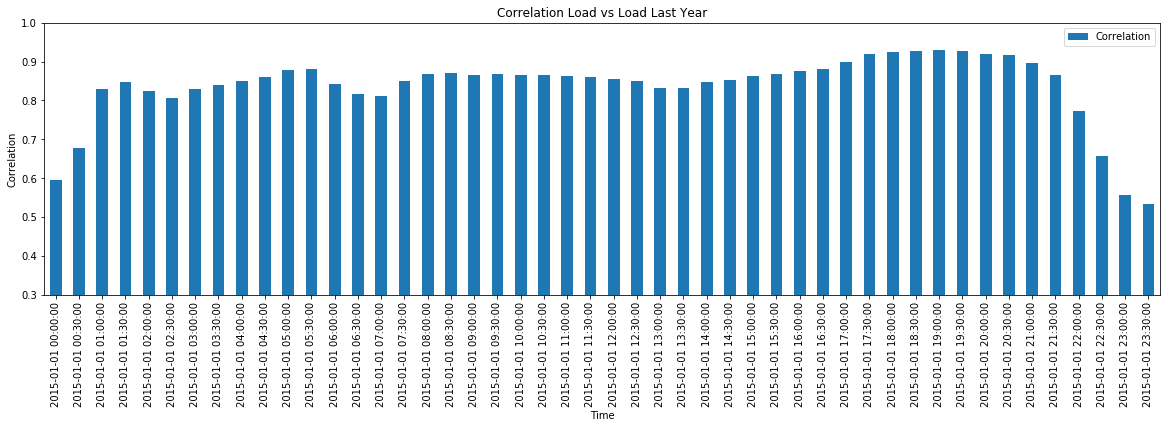

In [9]:
hourlycorrelation.plot(kind='bar', figsize=(20,5))
plt.title('Correlation Load vs Load Last Year')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.ylim(0.3, 1)

print(type(hourlycorrelation.index))

Using SDLY model in the morning has the least correlation (06:00-09:00), most correlation at night (18:00-21:00). Dip at around 3am.

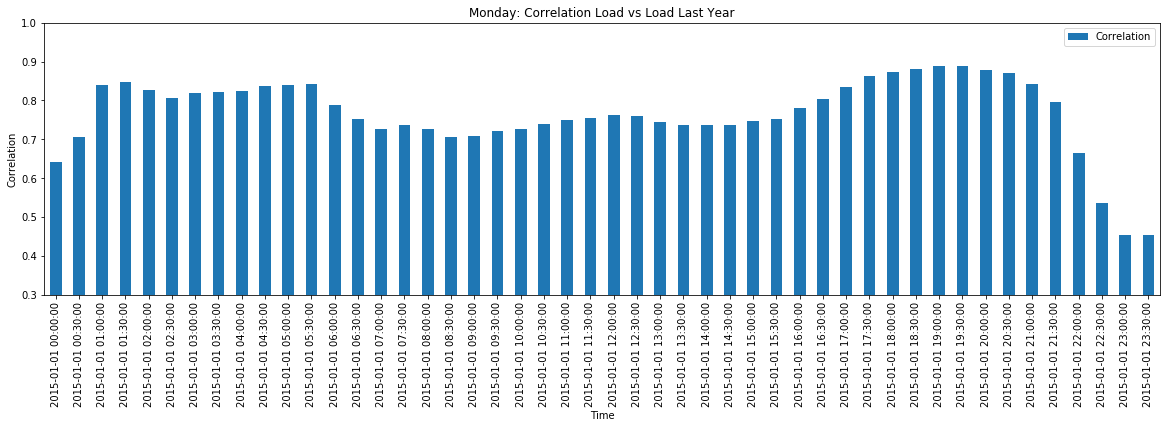

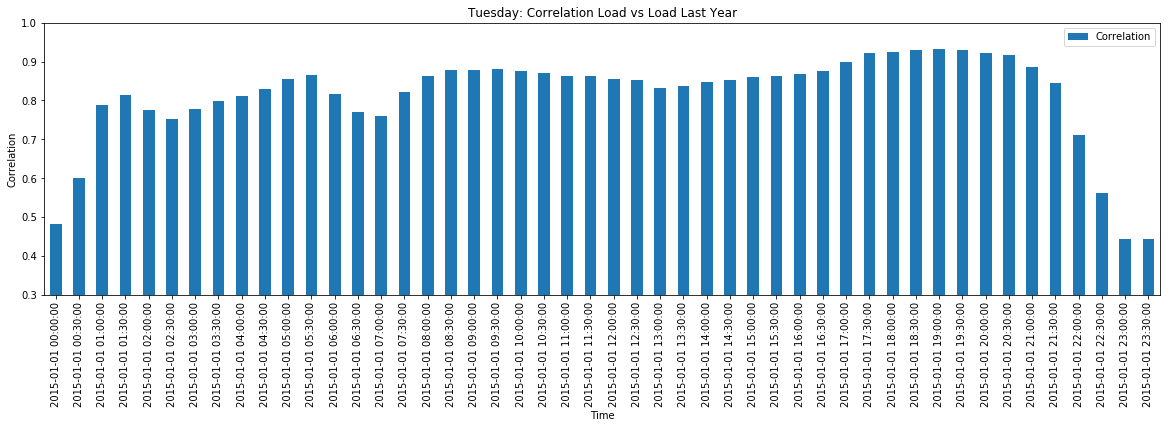

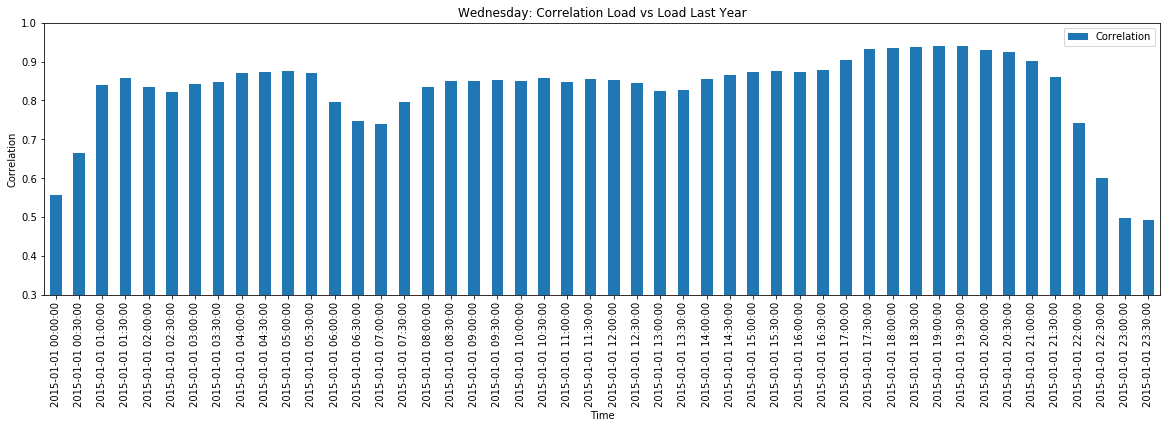

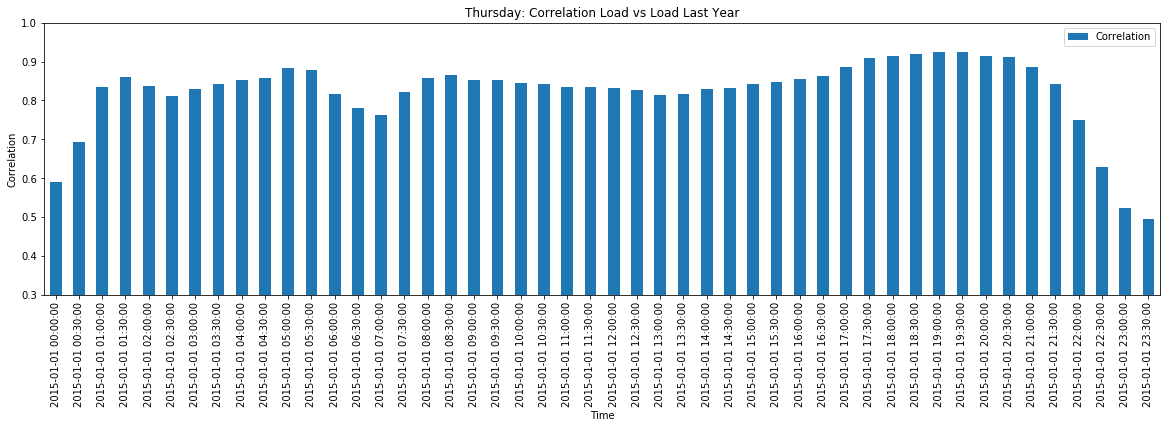

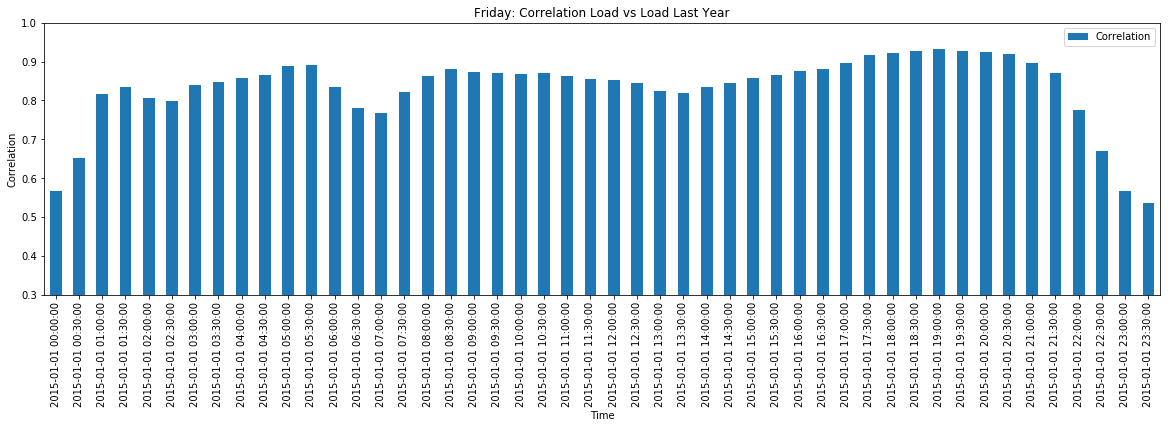

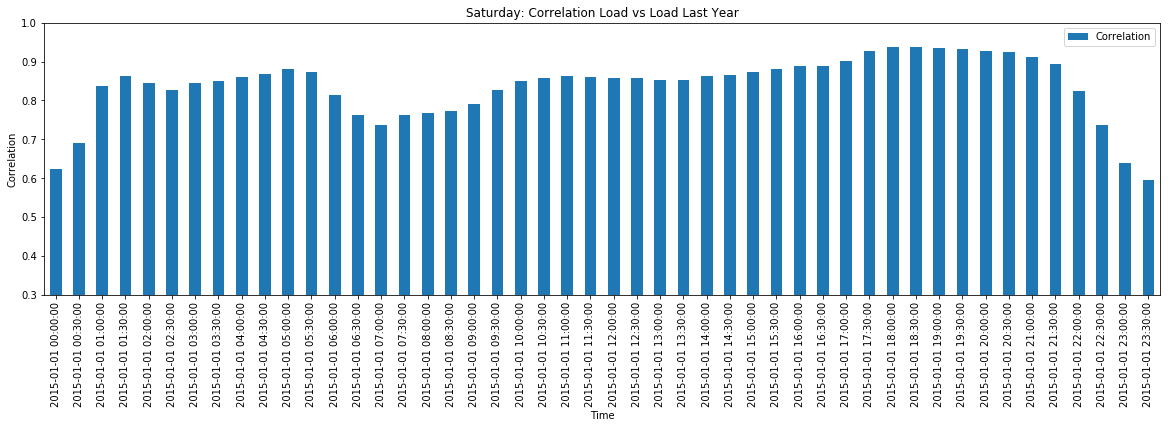

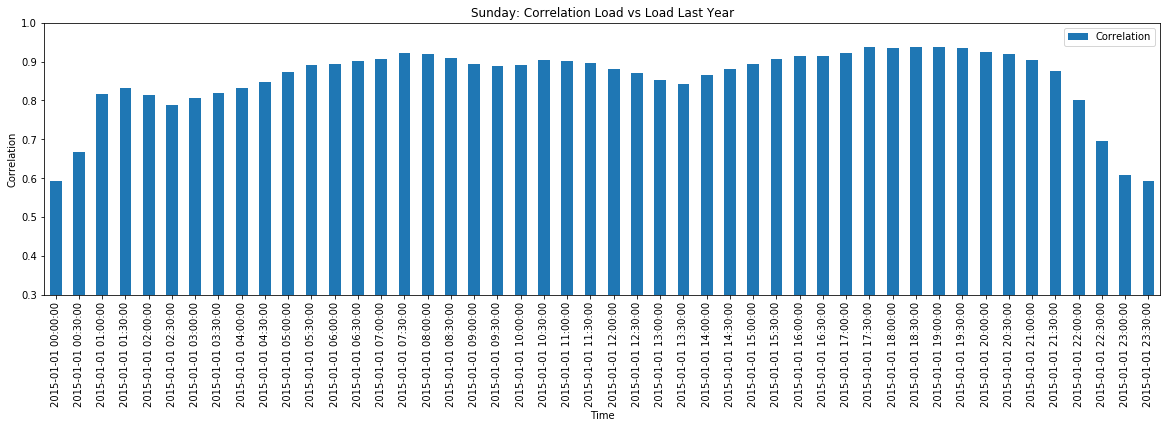

In [10]:
def day_hourlycorrelation(j):
    hourlycorrelation = pd.DataFrame(columns=['Hour', 'Correlation'])
    for i in range(0, 48):
        if i % 2 == 0:
            k = 0
        else:
            k = 30
        specificday = ranged_df[ranged_df['Dayofweek'] == j]
        specifichour = specificday[(specificday['Hour'] == int(i/2)) & (specificday['Minute'] == k)]     
        specifichourcorrelation = specifichour.corr()['Load']['Load Last Year']
        title = j
        hourlycorrelation = hourlycorrelation.append({'Hour': datetime(2015, 1, 1, int(i/2), k, 0, 0), 'Correlation': specifichourcorrelation}, ignore_index=True)
    return hourlycorrelation

for j in range(0, 7):
    hourlycorrelation = day_hourlycorrelation(j)
    hourlycorrelation.set_index('Hour', inplace=True)
    hourlycorrelation.plot(kind='bar', figsize=(20,5))
    plt.title(f'{calendar.day_name[j]}: Correlation Load vs Load Last Year')
    plt.xlabel('Time')
    plt.ylabel('Correlation')
    plt.ylim(0.3, 1)

# hourlycorrelation.plot(figsize=(20,20))
# plt.title('Correlation Load vs Load Last Year')
# plt.xlabel('Time')
# plt.ylabel('Correlation')

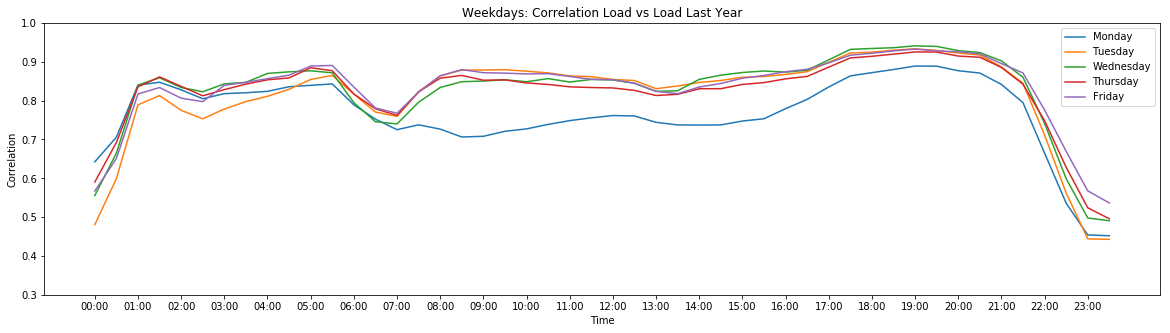

In [11]:
plt.figure(figsize=(20,5))
for j in range(0, 5):
    hourlycorrelation = day_hourlycorrelation(j)
    hourlycorrelation.set_index('Hour', inplace=True)
    plt.plot(hourlycorrelation.index.time, hourlycorrelation['Correlation'])
    
plt.title(f'Weekdays: Correlation Load vs Load Last Year')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.ylim(0.3, 1)
plt.xticks(hourlycorrelation.index.time[0::2])
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

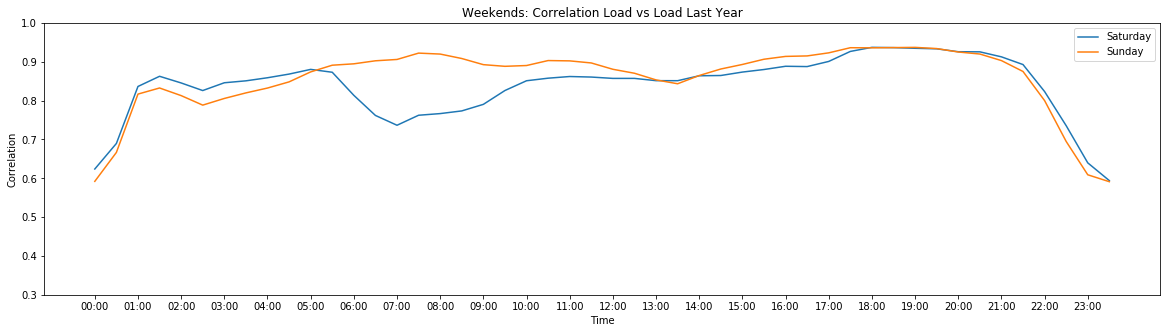

In [12]:
plt.figure(figsize=(20,5))
for j in range(5, 7):
    hourlycorrelation = day_hourlycorrelation(j)
    hourlycorrelation.set_index('Hour', inplace=True)
    plt.plot(hourlycorrelation.index.time, hourlycorrelation['Correlation'])
    
plt.title(f'Weekends: Correlation Load vs Load Last Year')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.ylim(0.3, 1)
plt.xticks(hourlycorrelation.index.time[0::2])
plt.legend(['Saturday', 'Sunday'])

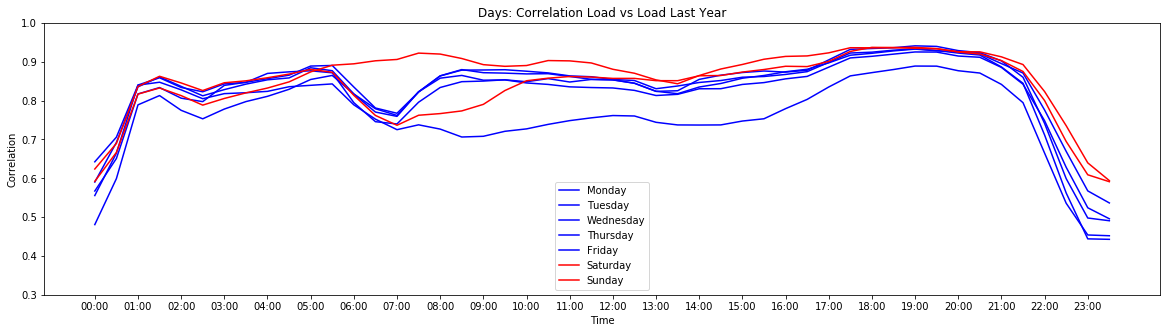

In [13]:
plt.figure(figsize=(20,5))
for j in range(0, 7):
    if (j < 5):
        color = 'blue'
    else:
        color = 'red'
    hourlycorrelation = day_hourlycorrelation(j)
    hourlycorrelation.set_index('Hour', inplace=True)
    plt.plot(hourlycorrelation.index.time, hourlycorrelation['Correlation'], color=color)
    
plt.title(f'Days: Correlation Load vs Load Last Year')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.ylim(0.3, 1)
plt.xticks(hourlycorrelation.index.time[0::2])
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# hourlycorrelation.plot(figsize=(20,20))
# plt.title('Correlation Load vs Load Last Year')
# plt.xlabel('Time')
# plt.ylabel('Correlation')